In [20]:
import custom_environments
import os
import pandas as pd
import numpy as np

In [21]:
# Set up environment

machines_data = []

print ("Opening files machine data files:")
path_to_machine_data = os.path.join(os.getcwd(), "machine_data")
for filename in os.listdir(path_to_machine_data):
  df = pd.read_csv(os.path.join(path_to_machine_data, filename))
  machine_name = os.path.splitext(filename)[0]
  print(machine_name)
  print(df.head())
  machine_data = [np.float32(row[1]) for row in df.values.tolist()]
  machines_data.append(machine_data)

num_datacentres = 2
datacentre_mapping = {
  0: 0, 1: 0, 2: 0, 3: 0, 4: 0,
  5: 1, 6: 1, 7: 1, 8: 1, 9: 1,
}

Opening files machine data files:
m_1932
   time_step  cpu_util_percent
0          0         36.444444
1          1         33.750000
2          2         31.250000
3          3         35.600000
4          4         34.800000
m_1933
   time_step  cpu_util_percent
0          0          5.240000
1          1          5.000000
2          2          5.470588
3          3          5.923077
4          4          5.153846
m_1934
   time_step  cpu_util_percent
0          0         46.800000
1          1         43.857143
2          2         52.000000
3          3         54.500000
4          4         39.750000
m_1935
   time_step  cpu_util_percent
0          0         40.863636
1          1         39.500000
2          2         37.833333
3          3         38.875000
4          4         38.000000
m_1936
   time_step  cpu_util_percent
0          0         38.200000
1          1         39.636364
2          2         33.000000
3          3         31.500000
4          4         32.750000
m

In [22]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gymnasium as gym
import matplotlib.pyplot as plt

In [23]:
# Test main code
env = gym.make('custom_environments/MultiDataCenterEnvironment', 
                    machines_data=machines_data, 
                    datacentre_mapping=datacentre_mapping, 
                    num_datacentres=num_datacentres
                  )


terminated = False
done = False
env.reset()
time = 0
random_action_ret = 0
while not (done or terminated):
  random_action = np.random.randint(0, 11)
  observation, reward, done, terminated, info = env.step(random_action)
  flattened_observation = np.concatenate((
                                            (np.array(observation["machines_curr_state"]) / 100).ravel(), 
                                            (observation["workload"] / 100).ravel(), 
                                            np.array([0. if (observation["workload_datacentre"] == 0) else 1.])
                                        ))
  flattened_normalised_observation = (flattened_observation-np.min(flattened_observation))/(np.max(flattened_observation)-np.min(flattened_observation))
  print(time)
  print(flattened_observation)
  print("Reward: ", reward)
  random_action_ret += reward
  time += 1

print ("Return:", random_action_ret)

0
[0.33750001 0.05       0.43857142 0.39500001 0.39636365 0.44999999
 0.28999999 0.49000001 0.44999999 0.23999999 0.16987081 1.        ]
Reward:  100
1
[0.3125     0.05470588 0.51999998 0.37833333 0.33000001 0.36333331
 0.352      0.4735294  0.41       0.24600001 0.3500222  0.        ]
Reward:  100
2
[0.35599998 0.05923077 0.54500002 0.38874999 0.315      0.38666669
 0.47555557 0.43235293 0.37       0.266      0.06073121 0.        ]
Reward:  50.0
3
[0.34799999 0.05153846 0.39750001 0.38       0.32749999 0.31
 0.33200002 0.39117646 0.34999999 0.25600001 0.01902977 0.        ]
Reward:  100
4
[0.34       0.06       0.44       0.36837208 0.3425     0.29333335
 0.36703706 0.34999999 0.33000001 0.257      0.84183174 1.        ]
Reward:  50.0
5
[0.47545457 0.06       0.44166669 0.3567442  0.39900002 0.3888889
 0.46333331 0.41999999 0.34666669 0.39857143 0.49191326 1.        ]
Reward:  67
6
[0.354      0.05571429 0.44090909 0.34511626 0.28999999 0.33333331
 0.52777779 0.35636365 0.31166667 0.3

In [24]:
def run_experiment(NUM_RUNS = 1, EPSILON_DECAY = 0.97, NUM_EPISODES=300, ddqn=False):
    print("DDQN:", ddqn)
    EPSILON_START = 1
    EPSILON_MIN = 0.001

    # Hyperparameters
    INPUT_LAYER_SIZE = 12 # 10 machines + workload + workload datacentre
    OUTPUT_LAYER_SIZE = 11 # 10 machines (1 action per machine) + noop action
    POLICY_NET_LAYER_SIZES = [INPUT_LAYER_SIZE, 512, OUTPUT_LAYER_SIZE]
    TARGET_NET_LAYER_SIZES = [INPUT_LAYER_SIZE, 512, OUTPUT_LAYER_SIZE]
    LEARNING_RATE = 0.0004
    REPLAY_BUFFER_SIZE = 30_000
    REPLAY_BUFFER_MINIBATCH_SIZE = 64
    NETWORK_SYNC_FREQUENCY = 50
    
    env = gym.make('custom_environments/MultiDataCenterEnvironment', 
                    machines_data=machines_data, 
                    datacentre_mapping=datacentre_mapping, 
                    num_datacentres=num_datacentres
                  )
    runs_results = []
    
    for run in range(NUM_RUNS):
        print(f"Starting run {run+1} of {NUM_RUNS}")
        policy_net = DQN(POLICY_NET_LAYER_SIZES)
        target_net = DQN(TARGET_NET_LAYER_SIZES)
        EPSILON = EPSILON_START
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
        memory = ReplayBuffer(REPLAY_BUFFER_SIZE)

        steps_done = 0

        episode_returns = []

        for i_episode in range(NUM_EPISODES):
            print("episode ", i_episode+1, "/", NUM_EPISODES)

            observation, info = env.reset()
            flattened_observation = np.concatenate((
                                            (np.array(observation["machines_curr_state"]) / 100).ravel(), 
                                            (observation["workload"] / 100).ravel(), 
                                            np.array([0. if (observation["workload_datacentre"] == 0) else 1.]) # one hot encode the datacentres
                                        ))
            state = torch.tensor(flattened_observation).float()

            done = False
            terminated = False
            ret = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(EPSILON, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                ret += reward
                flattened_observation = np.concatenate((
                                            (np.array(observation["machines_curr_state"]) / 100).ravel(), 
                                            (observation["workload"] / 100).ravel(), 
                                            np.array([0. if (observation["workload_datacentre"] == 0) else 1.]) # one hot encode the datacentres
                                        ))
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(flattened_observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                steps_done += 1

                # Perform one step of the optimization (on the policy network)
                if not memory.get_curr_size() < REPLAY_BUFFER_MINIBATCH_SIZE:
                    transitions = memory.sample(REPLAY_BUFFER_MINIBATCH_SIZE)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones, ddqn=ddqn)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()

                if steps_done % NETWORK_SYNC_FREQUENCY == 0:
                    update_target(target_net, policy_net)

                if done or terminated:
                    episode_returns.append(ret)

            # Update the target network, copying all weights and biases in DQN
            # if i_episode % NETWORK_SYNC_FREQUENCY == 0: 
            #     update_target(target_net, policy_net)

            # Update epsilon
            EPSILON = max(EPSILON * EPSILON_DECAY, EPSILON_MIN)
        runs_results.append(episode_returns)
    print('Complete')
    return policy_net, runs_results


# def run_trained_policy(policy_net, NUM_RUNS = 5, NUM_EPISODES=300):
#     env = gym.make('custom_environments/MultiDataCenterEnvironment', 
#                     machines_data=machines_data, 
#                     datacentre_mapping=datacentre_mapping, 
#                     num_datacentres=num_datacentres
#                   )
#     runs_results = []

#     for run in range(NUM_RUNS):
#         print(f"Starting run {run+1} of {NUM_RUNS}")
#         steps_done = 0

#         episode_durations = []

#         for i_episode in range(NUM_EPISODES):
#             if (i_episode+1) % 50 == 0:
#                 print("episode ", i_episode+1, "/", NUM_EPISODES)

#             observation, info = env.reset()
#             state = torch.tensor(observation).float()

#             done = False
#             terminated = False
#             t = 0
#             while not (done or terminated):
#                 # Select and perform an action
#                 action = epsilon_greedy(0, policy_net, state)

#                 observation, reward, done, terminated, info = env.step(action)
#                 next_state = torch.tensor(observation).reshape(-1).float()

#                 # Move to the next state
#                 state = next_state

#                 steps_done += 1

#                 if done or terminated:
#                     episode_durations.append(t + 1)
#                 t += 1

#         runs_results.append(episode_durations)
#     print('Complete')
#     return runs_results

In [25]:
 # Run DQN and DDQN
NUM_EPISODES = 100
ddqn_policy_net, ddqn_runs_results = run_experiment(NUM_EPISODES=NUM_EPISODES, ddqn=True)

DDQN: True
Starting run 1 of 1
episode  1 / 100
episode  2 / 100
episode  3 / 100
episode  4 / 100
episode  5 / 100
episode  6 / 100
episode  7 / 100
episode  8 / 100
episode  9 / 100
episode  10 / 100
episode  11 / 100
episode  12 / 100
episode  13 / 100
episode  14 / 100
episode  15 / 100
episode  16 / 100
episode  17 / 100
episode  18 / 100
episode  19 / 100
episode  20 / 100
episode  21 / 100
episode  22 / 100
episode  23 / 100
episode  24 / 100
episode  25 / 100
episode  26 / 100
episode  27 / 100
episode  28 / 100
episode  29 / 100
episode  30 / 100
episode  31 / 100
episode  32 / 100
episode  33 / 100
episode  34 / 100
episode  35 / 100
episode  36 / 100
episode  37 / 100
episode  38 / 100
episode  39 / 100
episode  40 / 100
episode  41 / 100
episode  42 / 100
episode  43 / 100
episode  44 / 100
episode  45 / 100
episode  46 / 100
episode  47 / 100
episode  48 / 100
episode  49 / 100
episode  50 / 100
episode  51 / 100
episode  52 / 100
episode  53 / 100
episode  54 / 100
episod

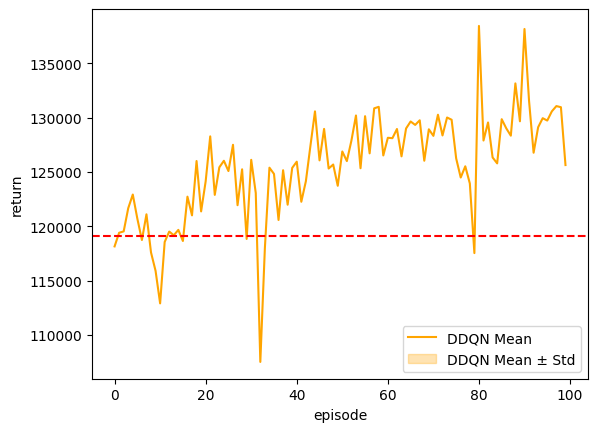

In [26]:
ddqn_results = torch.tensor(ddqn_runs_results)
ddqn_means = ddqn_results.float().mean(0)
ddqn_stds = ddqn_results.float().std(0)

plt.plot(torch.arange(NUM_EPISODES), ddqn_means, label="DDQN Mean", color='orange')
plt.ylabel("return")
plt.xlabel("episode")

plt.fill_between(np.arange(NUM_EPISODES), ddqn_means + ddqn_stds, ddqn_means - ddqn_stds, alpha=0.3, label=f"DDQN Mean ± Std", color='orange')
plt.axhline(y=random_action_ret, color='r', linestyle='--')
plt.legend(loc='lower right')
plt.show()